In [16]:
from skimage import feature
from imutils import paths
import numpy as np
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow

# Metode Processing

In [17]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)
		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding
		return image

# Feature Extraction

HOG

In [18]:
def quantify_image_hog(image): # Histogram of Oriented Gradient features
	features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
	return features

LBP

In [19]:
def quantify_image_lbp(image): # Local Binary Pattern features
  features = feature.local_binary_pattern(image, 24, 8, method="uniform")
  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))
  hist = hist.astype("float")
  hist /= (hist.sum() + 1e-7)
  return hist

### Testing Preprocess

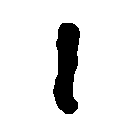

HOG
[0. 0. 0. ... 0. 0. 0.] 4356
LBP
[0.         0.         0.         0.         0.         0.
 0.         0.00219727 0.00146484 0.00317383 0.00256348 0.00482178
 0.00750732 0.09362793 0.00799561 0.04125977 0.01171875 0.06835937
 0.01184082 0.03979492 0.00817871 0.0355835  0.00384521 0.00592041
 0.6461792  0.00396729] 26


In [20]:
image_test = cv.imread('/content/drive/My Drive/Bootcamp ML2020/untuk_assignment13/bonus assignment 13/number/testing/one/img_39350.jpg')
image_test_preprocessed = preprocess(image_test, image_size=128)
cv2_imshow(image_test)
cv2_imshow(image_test_preprocessed)
features_hog = quantify_image_hog(image_test_preprocessed)
features_lbp = quantify_image_lbp(image_test_preprocessed)
print("HOG")
print(features_hog, len(features_hog))
print("LBP")
print(features_lbp, len(features_lbp))

### Split Dataset

In [21]:
def load_split(path, image_size=200, extraction_method='hog'):
	image_paths = list(paths.list_images(path))
	data = []
	labels = []

	for image_path in image_paths:
		label = image_path.split(os.path.sep)[-2]

		image = cv.imread(image_path)
		image = preprocess(image, image_size=image_size)
		
		if extraction_method == 'hog':
			features = quantify_image_hog(image)
		elif extraction_method == 'lbp':
			features = quantify_image_lbp(image)

		data.append(features)
		labels.append(label)

	return (np.array(data), np.array(labels))

### Load Dataset

In [22]:
dataset_dir = '/content/drive/My Drive/Bootcamp ML2020/untuk_assignment13/bonus assignment 13/number'
trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

### Set ukuran yang akan di resize dan metode feature extraction

In [39]:
resize_image_size = 128 # Masing-masing gambar perlu diresize menjadi suatu ukuran yang tetap
extraction_method = 'hog' # 'lbp' atau 'hog'

In [24]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# label_train = le.fit_transform(label_train)
# label_test = le.transform(label_test)

In [25]:
# label_test

# Soal Bonus

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [29]:
def training(resize_image_size, extraction_method):
  (feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
  (feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)
  # print("Data loaded!")

  le = LabelEncoder()
  label_train = le.fit_transform(label_train)
  label_test = le.transform(label_test)

  #LOGISTIC REGRESSION
  logreg = LogisticRegression()
  logreg.fit(feature_train, label_train)
  predictions = logreg.predict(feature_test)
  classification_report(label_test, predictions)
  print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(feature_test, label_test))) # .score() -> Accuracy
  print("F1", f1_score(label_test, predictions, average="macro"))
  print("Precision", precision_score(label_test, predictions, average="macro"))
  print("Recall", recall_score(label_test, predictions, average="macro"))

  #SVM kernel rbf
  def sv_krl(kertype,kername):
    classifier_rbf = SVC(kernel = kertype)
    classifier_rbf.fit(feature_train, label_train)
    predictions = classifier_rbf.predict(feature_test)
    classification_report(label_test, predictions)
    print('Accuracy of SVM',kername,'on test set: {:.2f}'.format(classifier_rbf.score(feature_test, label_test)))
    print("F1", f1_score(label_test, predictions, average="macro"))
    print("Precision", precision_score(label_test, predictions, average="macro"))
    print("Recall", recall_score(label_test, predictions, average="macro"))
  krn=['linear','rbf','poly']
  nama=['linear','rbf','poly']
  for i in range(len(krn)):
    sv_krl(krn[i],nama[i])


  #RANDOM FOREST
  def rnd_est(nestimator):
    model = RandomForestClassifier(n_estimators=nestimator, random_state=10)
    model.fit(feature_train, label_train)
    predictions = model.predict(feature_test)
    classification_report(label_test, predictions)
    print('Accuracy of Random Forest estimator',nestimator,'on test set: {:.2f}'.format(model.score(feature_test, label_test)))
    print("F1", f1_score(label_test, predictions, average="macro"))
    print("Precision", precision_score(label_test, predictions, average="macro"))
    print("Recall", recall_score(label_test, predictions, average="macro"))
  estimator=[50,100,200]
  for i in range(len(estimator)):
    rnd_est(estimator[i])



In [36]:
training(128, 'hog')

Accuracy of logistic regression classifier on test set: 0.99
F1 0.9922219259127566
Precision 0.992280306622412
Recall 0.9922222222222222
Accuracy of SVM linear on test set: 0.99
F1 0.9922219259127566
Precision 0.992280306622412
Recall 0.9922222222222222
Accuracy of SVM rbf on test set: 1.00
F1 0.995553682124323
Precision 0.9955628400776687
Recall 0.9955555555555554
Accuracy of SVM poly on test set: 1.00
F1 0.9966648086368141
Precision 0.9966666419750343
Recall 0.9966666666666666
Accuracy of Random Forest estimator 50 on test set: 0.99
F1 0.9933370000407412
Precision 0.993355408388521
Recall 0.9933333333333333
Accuracy of Random Forest estimator 100 on test set: 0.99
F1 0.992229598754955
Precision 0.9922480620155039
Recall 0.9922222222222222
Accuracy of Random Forest estimator 200 on test set: 0.99
F1 0.9933370000407412
Precision 0.993355408388521
Recall 0.9933333333333333


In [31]:
training(128, 'lbp')

Accuracy of logistic regression classifier on test set: 0.71
F1 0.6645240405045216
Precision 0.8099564260410301
Recall 0.7122222222222222


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy of SVM linear on test set: 0.66
F1 0.5462516117148647
Precision 0.4870420995079278
Recall 0.6577777777777778
Accuracy of SVM rbf on test set: 0.87
F1 0.8635932912312209
Precision 0.8758672443874319
Recall 0.8655555555555555
Accuracy of SVM poly on test set: 0.91
F1 0.9050515435490906
Precision 0.9104413145795446
Recall 0.9055555555555556
Accuracy of Random Forest estimator 50 on test set: 0.97
F1 0.9676561886395074
Precision 0.9682133901649275
Recall 0.9677777777777777
Accuracy of Random Forest estimator 100 on test set: 0.97
F1 0.9666465151831005
Precision 0.9674213311055416
Recall 0.9666666666666667
Accuracy of Random Forest estimator 200 on test set: 0.97
F1 0.96549466163638
Precision 0.9662887748541205
Recall 0.9655555555555555


akurasi tertinggi yang didapat bearada pada algoritma **SVM RBF** dengan nilai akurasi **100%** dan F1 **99%**. Hal ini bisa terjadi dikarenakan selain data training yang banyak, juga pola setiap gambar yang digunakan itu sama

In [40]:
(feature_train, label_train) = load_split(trainingPath, image_size=128, extraction_method='hog')
(feature_test, label_test) = load_split(testingPath, image_size=128, extraction_method='hog')
le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)
testing_paths = list(paths.list_images(testingPath))
images = []
random_forest=RandomForestClassifier(n_estimators=50, random_state=10)
random_forest.fit(feature_train, label_train)

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "zero" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

In [41]:
testing_paths = list(paths.list_images(testingPath))
images = []
random_forest=RandomForestClassifier(n_estimators=50, random_state=10)
random_forest.fit(feature_train, label_train)

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "zero" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

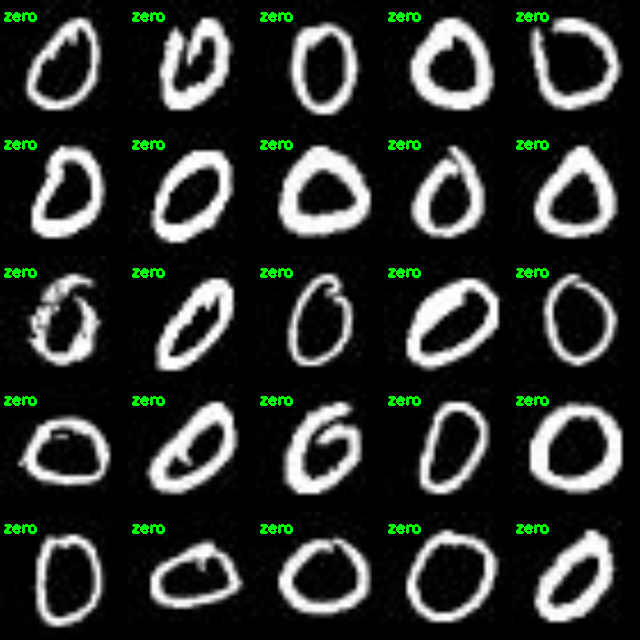

In [42]:
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

Untuk Montage gambar, output yang ditampilkan masih sesuai folder, tidak secara acak dalam folder testing. saat ini saya masih mengotak atik bagaimana caranya agar yang ditesting itu dapat secara acak, tidak per folder 0 1 dan 2. menurut saya cara yang diatas ini lebih tepat digunakan untuk folder yang berisi campuran angka 0 1 dan 2

# Membuat Data Testing Baru

In [61]:
image_test=cv.imread('/content/drive/My Drive/Bootcamp ML2020/untuk_assignment13/bonus assignment 13/number/testing_image.jpeg')

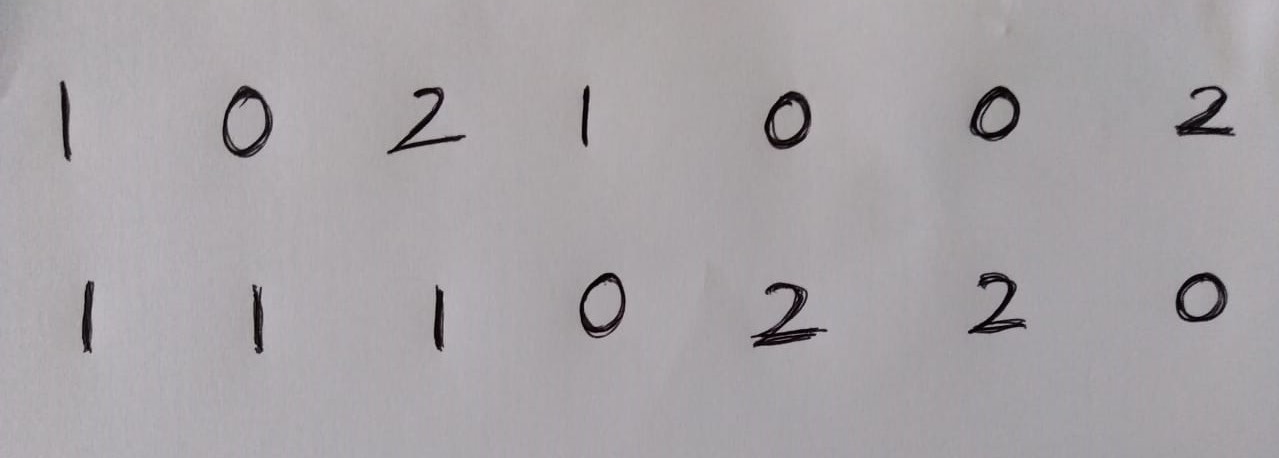

In [79]:
cv2_imshow(image_test)

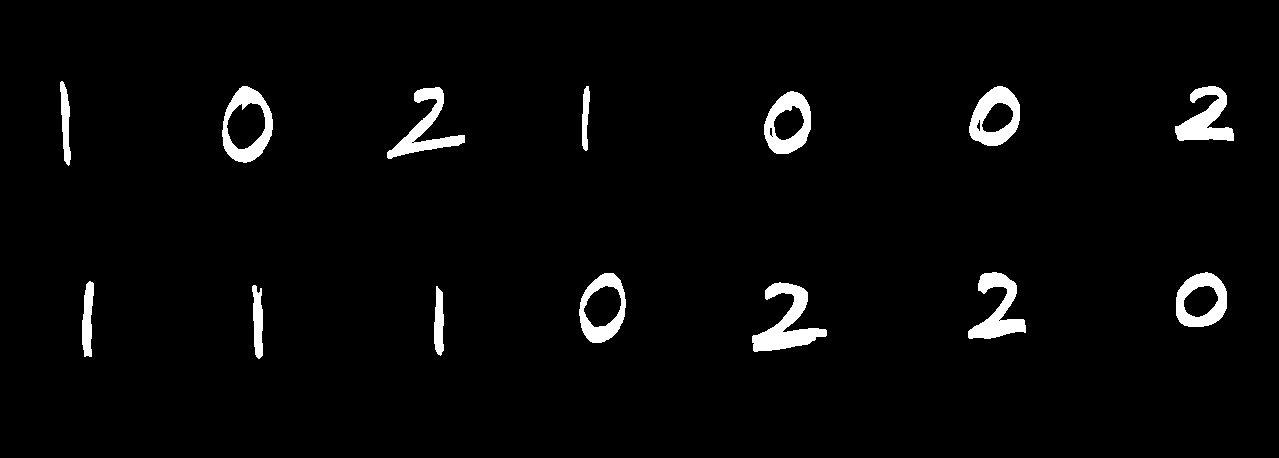

Contour #0 434 286 10 65 419.0
Contour #1 252 285 11 69 445.0
Contour #2 752 282 75 65 1285.5
Contour #3 82 281 12 71 506.5
Contour #4 579 273 47 65 2203.5
Contour #5 1176 272 51 50 1949.0
Contour #6 968 272 58 62 1031.5
Contour #7 764 91 47 58 1963.5
Contour #8 387 87 78 67 798.5
Contour #9 1175 86 59 50 971.5
Contour #10 969 86 51 55 1953.0
Contour #11 582 86 8 60 258.5
Contour #12 222 86 51 72 2593.5
Contour #13 60 81 11 80 420.5


In [63]:
def gaus_filter(image,kernel):
  blur=cv.GaussianBlur(image_test, (kernel, kernel), 0)
  return blur
def filtering_median(image_test,kernel):
  blur=cv.medianBlur(image_test, kernel)
  return blur
image_gray = cv.cvtColor(image_test, cv.COLOR_BGR2GRAY)
image_gray_blur = filtering_median(image_gray,3)
# cv2_imshow(image_gray_blur)
thresholding_value, thresholding_result = cv.threshold(image_gray_blur, 100, 255, cv.THRESH_BINARY)
# print(thresholding_value)
# print(thresholding_result)
thresholding_result=cv.bitwise_not(thresholding_result)
# cv2_imshow(thresholding_result)
dilation = cv.dilate(thresholding_result,(7,7), iterations = 5)
cv2_imshow(dilation)
# thresholding_result = cv.bitwise_not(thresholding_result)
contours, hierarchy = cv.findContours(thresholding_result, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# print(contours)
# len(contours)
# area = cv.contourArea(contours[0])
# area
area_array=[]
for index, contour in enumerate(contours):
  x,y,w,h=cv.boundingRect(contour)
  area=cv.contourArea(contour)
  area_array.append([index,area,w,h])
  print("Contour #"+ str(index),x,y,w,h,area)



In [64]:
df_area=pd.DataFrame(area_array)
df_area.columns=['index','area','width','height']
df_sort=df_area.sort_values(by=['area'],ascending=False)
df_sort.head(20)

,index,area,width,height
12,12,2593.5,51,72
4,4,2203.5,47,65
7,7,1963.5,47,58
10,10,1953.0,51,55
5,5,1949.0,51,50
2,2,1285.5,75,65
6,6,1031.5,58,62
9,9,971.5,59,50
8,8,798.5,78,67
3,3,506.5,12,71


In [75]:
test = df_area['area']
array=[]
directory_save='/content/drive/My Drive/Bootcamp ML2020/untuk_assignment13/bonus assignment 13/number/testing2'
for i,v in enumerate(test):
  if test[i]>400:
    array.append(i)
array.sort()
print(array)
os.chdir(directory_save)
for i,v in enumerate(array):
  x,y,w,h=cv.boundingRect(contours[v])
  gambar_test = image_test[y:y+h, x:x+w]
  resized = cv.resize(gambar_test, (h,w), interpolation=cv.INTER_AREA)
  cv.imwrite('test{}.jpg'.format(i), resized)
print(os.listdir(directory_save))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13]
['test0.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg', 'test7.jpg', 'test8.jpg', 'test9.jpg', 'test10.jpg', 'test11.jpg', 'test12.jpg']


In [76]:
testing_paths = list(paths.list_images(os.path.join(dataset_dir, "testing2")))
images = []
random_forest=RandomForestClassifier(n_estimators=50, random_state=10)
random_forest.fit(feature_train, label_train)

for testing_path in testing_paths[:25]:
	image1 = cv.imread(testing_path)
	output = image1.copy()
	output = cv.resize(output, (128, 128))

	image1 = preprocess(image1, image_size=128)

	if extraction_method == 'hog':
		features = quantify_image_hog(image1)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image1)
   
	preds = random_forest.predict([features])
	label = le.inverse_transform(preds)[0]
	color = (0, 255, 0) if label == "zero" else (0, 0, 255) if label=="one" else (0,255,255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

In [78]:
cv2_imshow(gambar_test)

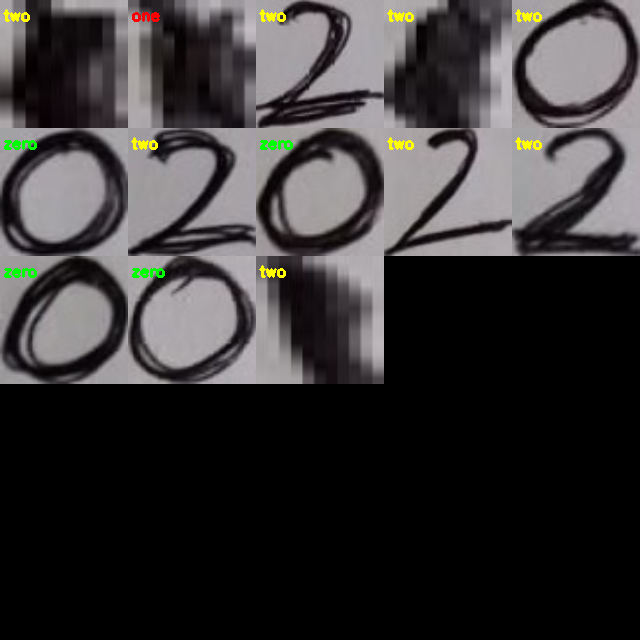

In [77]:
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

Untuk kendala saya disini adalah ketika menampilkan angka 1 menjadi tidak jelas karena angka 1 nya di fit sehingga angka 1 memenuhi ukuran gambar, namun untuk testingnya sudah baik

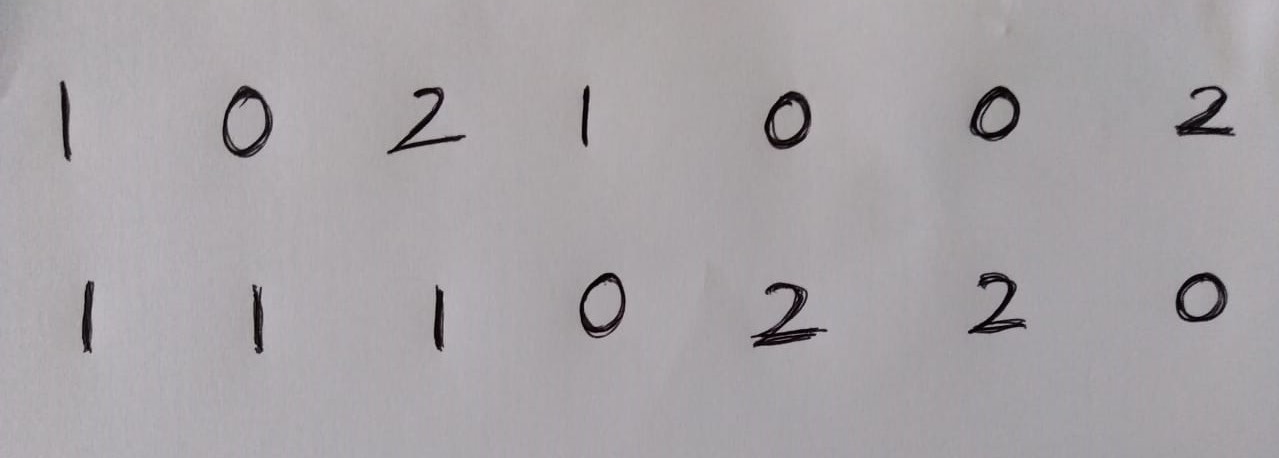

In [80]:
image_test_ori = image_test.copy()
image_height = image_test.shape[0]
image_width = image_test.shape[1]
image_area = image_height*image_width

cv2_imshow(image_test)

In [85]:
def preprocess2(image, image_size=128, resize=True):
	image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) # Ubah mehjadi grayscale
	
	if resize == True:
		image = cv.resize(image, (image_size, image_size)) # Resize gambar menjadi suatu ukuran (default = 128)
	
	image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] # Melakukan thresholding dan mengambil hasil gambar thresholding
	
	return image

In [89]:
image_test=preprocess2(image_test, resize=False)

In [101]:
def extract_object(image):
  contours = cv.findContours(image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[0]
  objects = []
  for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    objects.append({'image'  : image_test_ori[y:y+h, x:x+w],
                    'left'   : x,
                    'top'    : y,
                    'right'  : x+w,
                    'bottom' : y+h})
  return objects

In [105]:
objects=extract_object(image_test)

In [109]:
def apply_model(objects, image_ori, model):
  for obj in objects:
    image = obj['image']
    image = preprocess2(image, image_size=128)
    if extraction_method == 'pxb':
      features = quantify_image_pxb(image)
    elif extraction_method == 'hog':
      features = quantify_image_hog(image)
    elif extraction_method == 'lbp':
      features = quantify_image_lbp(image)

    preds = model.predict([features])
    label = le.inverse_transform(preds)[0]
    text = str(label)
    color = (0,255,0)
    text_org = (obj['left']-5,obj['top']-10)

    cv.rectangle(image_ori,(obj['left']-5,obj['top']-5),(obj['right']+5,obj['bottom']+5),color,2)
    cv.putText(image_ori,text,text_org,cv.FONT_HERSHEY_SIMPLEX,0.5,color,2)
  
  cv2_imshow(image_ori)

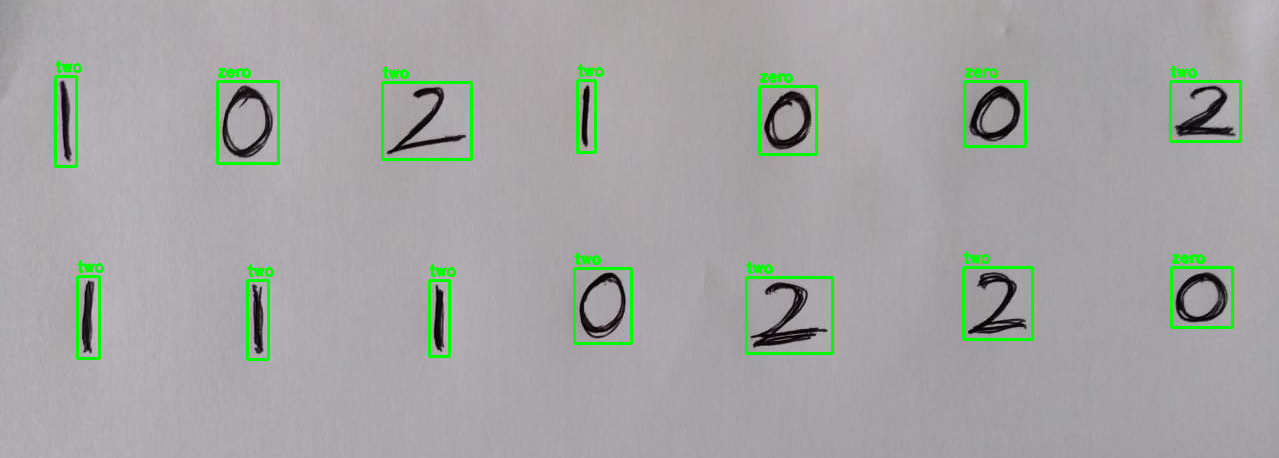

In [110]:
model = SVC(kernel='rbf')
model.fit(feature_train, label_train)
apply_model(objects, image_test_ori, model)

Disini saya masih mendapatkan error pada saat mengetest angka 1